In [1]:
import fsspec # imported first because of pl import error

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data_path = Path("data")

### Utility Funcs

## What's the minimum amount of data to achieve r2 > 0.7

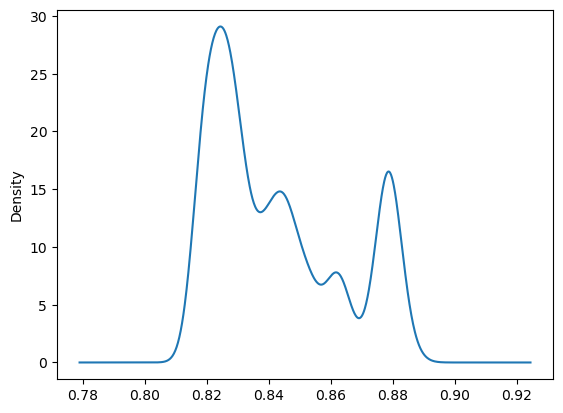

In [3]:
diversity = pd.read_csv(data_path / "stability_diversity_full.csv", index_col=0).sort_values("diversity")
diversity.diversity[1000:].plot.density()
plt.show()

### Load Protein Embeddings Dataset and Model

In [33]:
import torch
from torch.nn import functional as F

import pytorch_lightning as pl
import torchmetrics


class LitProteins(pl.LightningModule):
    """Training Protein Stability Regression Model"""
    
    # See for ddp: https://torchmetrics.readthedocs.io/en/latest/pages/lightning.html#logging-torchmetrics
    def __init__(self, model, hparams):
        super(LitProteins, self).__init__()
        self.model = model
        self.r2 = torchmetrics.R2Score()
        
        self.save_hyperparameters(hparams)
        self.conf = hparams
        #self.logger.log_hyperparams(params=hparams, metrics={})
        
    def forward(self, x):
        pred_stability = self.model(x)
        return pred_stability

    def do_step(self, batch, stage):
        X, y = batch
        y_hat = self.model(X)
        loss = F.mse_loss(y_hat, y)
        
        self.log(f'{stage}_r2_step', self.r2(y_hat, y))
        return y_hat, loss
    
    def step_log(self, loss, stage):
        self.log(f"{stage}_loss_step", loss, prog_bar=False, on_epoch=False)
    
    def epoch_log(self, avg_loss, stage):
        self.log(f'{stage}_r2_epoch', self.r2.compute(), prog_bar=True)
        self.log(f"{stage}_loss_epoch", avg_loss, on_step=False, on_epoch=True, prog_bar=True)
    
    def training_step(self, batch, batch_idx):
        y_hat, loss = self.do_step(batch, "train")
        self.step_log(loss, "train")
        return loss
    
    def validation_step(self, batch, batch_idx):
        y_hat, loss = self.do_step(batch, "valid")
        self.step_log(loss, "valid")
        return loss
    
    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([out["loss"] for out in outputs]).mean()
        self.epoch_log(avg_loss, "train")
    
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([out for out in outputs]).mean()
        self.epoch_log(avg_loss, "valid")
    
    def configure_optimizers(self):
        optimizer = self.conf["optimzer"]["object"](self.model.parameters(), lr=self.conf["optimzer"]["lr"])
        scheduler = self.conf["optimzer"]["scheduler"]["object"](optimizer, patience=self.conf["optimzer"]["scheduler"]["patience"])
        
        lr_scheduler = {
            "scheduler": scheduler,
            "monitor": "valid_loss_epoch",
            "name": self.conf["optimzer"]["scheduler"]["name"]
        }
        return [optimizer], [lr_scheduler]

In [35]:
from train import ProteinStabilityDataset, SubsetDiversitySampler, AttrDict
from torch.utils.data import SubsetRandomSampler

from models import ProteinMLP
import torch
import random

model = ProteinMLP()

# https://github.com/omry/omegaconf ??
conf = AttrDict()
conf.update(
    {
        "model_name" : "ProteinMLP",
        "data" : {
            "batch_size": 128, 
            "random_split": [8000, 2281],
            "sampling" : {
                "method": "diversity",
                "diversity_cutoff": 0.8,
                "max_size": int(8000 * 0.5)
            }
        },
        "max_epochs": 1,
        "optimzer": {
            "object" : torch.optim.SGD,
            "name" : torch.optim.SGD.__name__,
            "lr" : 1e-3,
            "scheduler" : {
                "object" : torch.optim.lr_scheduler.ReduceLROnPlateau,
                "name" : torch.optim.lr_scheduler.ReduceLROnPlateau.__name__,
                "patience" : 3
            }
        }
    }
)

mlp = LitProteins(model, conf)


trainer = pl.Trainer(
    default_root_dir = "logs", 
    gpus = 1,  
    max_epochs = conf.max_epochs, 
    log_every_n_steps = 10,
)

dataset = ProteinStabilityDataset(data_path / "stability.h5", ret_dict = False)
train_set, val_set = torch.utils.data.random_split(dataset, conf.data["random_split"])

# sampler = SubsetRandomSampler(range(int(len(train_set) * 0.7)))

sampler = SubsetDiversitySampler(
    set_indices = train_set.indices,
    diversity_path = data_path / "stability_diversity_full.csv",
    diversity_cutoff = conf.data["sampling"]["diversity_cutoff"],
    max_size = conf.data["sampling"]["max_size"]
)

dl_params = {
    "batch_size": conf.data["batch_size"],
    "num_workers" : 8,
    "pin_memory" : True,
    "drop_last" : True,
}

train_loader = torch.utils.data.DataLoader(train_set, sampler=sampler, **dl_params)
val_loader = torch.utils.data.DataLoader(val_set, **dl_params)

trainer.fit(mlp, train_loader, val_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

## Experiments

In [42]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning import loggers as pl_loggers
import shutil

from typing import List


def setup_conf(random_percent, cutoff, bs, sampling_dict, max_epochs):
    dataset_size = 10281
    
    conf = AttrDict()
    conf.update(
        {
            "experiment" : {
                "cutoff" : cutoff,
                "random_percent" : random_percent
                
            },
            "model_name" : "ProteinMLP",
            "data" : {
                "batch_size": 128, 
                "random_split": [int(dataset_size * train_percent), dataset_size - int(dataset_size * train_percent)],
                "sampling" : sampling_dict
            },
            "max_epochs": max_epochs,
            "optimzer": {
                "object" : torch.optim.SGD,
                "name" : torch.optim.SGD.__name__,
                "lr" : 1e-3,
                "scheduler" : {
                    "object" : torch.optim.lr_scheduler.ReduceLROnPlateau,
                    "name" : torch.optim.lr_scheduler.ReduceLROnPlateau.__name__,
                    "patience" : 3
                }
            }
        }
    )
    return conf


def setup_data(conf : AttrDict, 
               sampling : str, 
               diversity_cutoff : float, 
               max_size : int, 
               random_percent : float, 
               random_split: List[int]):
    # update conf
    conf.data["random_split"] = random_split
    
    conf.data["sampling_name"] = sampling
    conf.data[f"sampling_diversity"] = dict()
    conf.data[f"sampling_diversity"]["diversity_cutoff"] = diversity_cutoff
    conf.data[f"sampling_diversity"]["max_size"] = max_size
    conf.data[f"sampling_diversity"]["diversity_path"] = data_path / "stability_diversity_full.csv"
    conf.data[f"sampling_random"]["random_percent"] = random_percent
    
    dataset = ProteinStabilityDataset(data_path / "stability.h5", ret_dict = False)
    train_set, val_set = torch.utils.data.random_split(
        dataset, 
        conf.data["random_split"]
    )
    
    if "diversity" == conf.data[f"sampling_{sampling}"]:
        sampler = SubsetDiversitySampler(
            set_indices = train_set.indices,
            **conf.data["sampling_diversity"]
        )
        print(f"=== USING {len(sampler)} out of {len(train_set)} samples ===")
        print(f"=== SIZE WAS DETERMINED BY {sampler.stopped_by} ===")
        
    elif "random" == conf.data[f"sampling_{sampling}"]:
        random_percent = conf.data["sampling_random"]["random_percent"]
        sampler = SubsetRandomSampler(range(int(len(train_set) * random_percent)))
        print(f"=== USING {len(sampler)} out of {len(train_set)} samples ===")
        print(f"=== SIZE WAS DETERMINED BY RANDOM PERCENT OF {random_percent} ===")
         
    else:
        wrong_sampling = conf.data["sampling_name"]
        raise ValueError(f"Sampling Method {wrong_sampling} is not valid.")
        
    dl_params = {"num_workers" : 8, "pin_memory" : True}
    
    train_loader = torch.utils.data.DataLoader(train_set, batch_size = conf.data["batch-size"], sampler=sampler, **dl_params)
    valid_loader = torch.utils.data.DataLoader(val_set, batch_size = conf.data["batch-size"] * 2, **dl_params)
    
    return {"train_loader": train_loader, "valid_loader": valid_loader}, conf

def setup_trainer(conf, ckpt_dir):
    model = ProteinMLP()
    net = LitProteins(model, conf)
    
    log_dir = Path(f"logs/{ckpt_dir}")
    ckpt_dir = log_dir / "models"
    
    if log_dir.exists():
        shutil.rmtree(log_dir)
        log_dir.mkdir()
        ckpt_dir.mkdir()
    
    trainer = pl.Trainer(
        logger=pl_loggers.TensorBoardLogger(log_dir),
        gpus=1, 
        max_epochs=conf.max_epochs, 
        log_every_n_steps=5,
        callbacks = [
            ModelCheckpoint(ckpt_dir), 
            EarlyStopping(monitor="valid_loss_epoch", patience=15, check_on_train_epoch_end=False),
            LearningRateMonitor(logging_interval='step')
        ]
    )
    
    return {"model" : net, "trainer" : trainer}, conf
    

def setup(data_path, 
          epochs=int(1e4), 
          bs = 256,
          sampling = "diversity", 
          diversity_cutoff = 0.82,
          max_div_percent = 0.9,
          random_percent = 0.5, 
          ckpt_dir = ''):
    
    sampling_dict = {}
    conf = setup_conf(random_percent=random_percent, cutoff=diversity_cutoff, bs=bs, sampling_dict=sampling_dict, max_epochs)
    data_dict, conf = setup_data(
        conf, 
        diversity_cutoff=diversity_cutoff,  
        max_size=max_size,  
        random_percent=random_percent, 
        random_split=random_split
    )
    trainer_dict, conf = setup_trainer(conf, ckpt_dir=ckpt_dir)
    experiment_conf = {
        "model": net, 
        "trainer": trainer,
        "train_loader": train_loader, 
        "valid_loader": valid_loader
    }
    return experiment_conf

SyntaxError: positional argument follows keyword argument (<ipython-input-42-dea3ec18412e>, line 124)

In [21]:
#exp = setup(data_path, epochs=15, diversity_sampling=True, max_div_percent=0.85, ckpt_dir="base")
#exp["trainer"].fit(exp["model"], exp["train_loader"], exp["valid_loader"])

In [22]:
from tqdm.autonotebook import tqdm

def run_experiment(data_path, epochs, max_randoms, cutoffs):
    conf = setup_conf()
    print("=== RUNNING RANDOM SAMPLING ===")
    for percent in tqdm(max_randoms):
        exp = setup(
            data_path, 
            epochs=epochs, 
            sampling="random", 
            random_percent=percent,
            ckpt_dir=f'stability_random_{percent}'
        )
        exp["trainer"].fit(exp["model"], exp["train_loader"], exp["valid_loader"])
    
    print("=== RUNNING DIVERSITY SAMPLING ===")
    for cut in tqdm(cutoffs):
        exp = setup(
            data_path, 
            epochs=epochs, 
            sampling="diversity",
            diversity_cutoff=cut, 
            max_div_percent=max_randoms[0],
            ckpt_dir=f'stability_cut_{cut}'
        )
        exp["trainer"].fit(exp["model"], exp["train_loader"], exp["valid_loader"])

In [23]:
random_percents = [0.9, 0.7, 0.5, 0.4, 0.3]
cutoffs = [0.75, 0.8, 0.83, 0.84, 0.86]

run_experiment(
    data_path=data_path, 
    epochs=40, 
    max_randoms = random_percents, 
    cutoffs = cutoffs
)

=== RUNNING RANDOM SAMPLING ===


  0%|          | 0/4 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING 7864 out of 8738 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.9 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING 6116 out of 8738 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.7 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING 5242 out of 8738 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.6 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING 4369 out of 8738 samples ===
=== SIZE WAS DETERMINED BY RANDOM PERCENT OF 0.5 ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

=== RUNNING DIVERSITY SAMPLING ===


  0%|          | 0/5 [00:00<?, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING 7864 out of 8738 samples ===
=== SIZE WAS DETERMINED BY max size reached ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING 7864 out of 8738 samples ===
=== SIZE WAS DETERMINED BY max size reached ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING 4693 out of 8738 samples ===
=== SIZE WAS DETERMINED BY cutoff ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING 3561 out of 8738 samples ===
=== SIZE WAS DETERMINED BY cutoff ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type       | Params
-------------------------------------
0 | model | ProteinMLP | 1.8 M 
1 | r2    | R2Score    | 0     
-------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.348     Total estimated model params size (MB)


=== USING 1940 out of 8738 samples ===
=== SIZE WAS DETERMINED BY cutoff ===


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]